# MAT330 - 3. Try a linear model with feature preprocessing
<span style="color:blue"> ** This notebook train a linear model and make a preprocessing of input features** </span>

<span style="color:blue"> ** - Extract quantitative 0d features with no transformation ** </span>

<span style="color:blue"> ** - Use One-hot encoding for qualitative features ** </span>

<span style="color:blue"> ** - Represent 2d image features (11x11) by a vector containing (mean, standard deviation, max value) ** </span>

<span style="color:red"> ** - Can you try other feature preprocessings and select the best features? ** </span>

<span style="color:red"> ** - Is there a way to select the best features given the results of a regression? ** </span>

In [1]:
%matplotlib inline
import os
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype

## Load data

In [2]:
#Specify the categorical features
categorical_features = ['basin','nature']


train_filename = 'https://raw.githubusercontent.com/brajard/MAT330-Practical-work/master/data/train.csv'
train_filename = './data/train.csv'

data_train = pd.read_csv(train_filename, dtype={cat: 'category' for cat in categorical_features})

# Extract the predictor (but not the target -> data leakage)
X = data_train.drop('target',axis=1, inplace=False)
y = data_train['target']

# Do the same with the test dataset
test_filename = 'https://raw.githubusercontent.com/brajard/MAT330-Practical-work/master/data/test.csv'
test_filename = './data/test.csv'

Xtest = pd.read_csv(test_filename, dtype={cat: 'category' for cat in categorical_features})


## Linear model

### 1. Feature selection

In [3]:
## Some exemple of function to compute new features

# compute the  max, mean and standard deviation of the wind inensity
def compute_wind(df):
    features_u = [name for name in df.columns if name.startswith('u_')]
    features_v = [name for name in df.columns if name.startswith('v_')]
    u = df.get(features_u)
    v = df.get(features_v)
    intensity = u.values**2 + v.values**2
    
    return df.assign(wind_mean = intensity.mean(axis=1),
                     wind_std = intensity.std(axis=1),
                    wind_max = intensity.max(axis=1))

# Compute the max, average and standard deviation of the pressure
def compute_zmean(df):
    features_z = [name for name in df.columns if name.startswith('z_')]
    z = df.get(features_z)
    return df.assign(z_mean = z.mean(axis=1),
                    z_std = z.std(axis=1),
                    z_max = z.max(axis=1))


In [4]:
from sklearn.preprocessing import StandardScaler


#Feature processing (on image)
X = compute_wind(X)
X = compute_zmean(X)
Xtest = compute_wind(Xtest)
Xtest = compute_zmean(Xtest)

#Features to use
features = ['latitude', 'instant_t','longitude', 'windspeed',
       'hemisphere', 'Jday_predictor', 'initial_max_wind',
       'max_wind_change_12h','dist2land',
            'wind_mean','wind_std','wind_max',
            'z_mean','z_std','z_max']


Xin = X.get(features)
Xin_test = Xtest.get(features)



# Dummy encoding of categorical features
Xcat = pd.get_dummies(X[categorical_features],prefix=categorical_features)
Xcat_test = pd.get_dummies(Xtest[categorical_features],prefix=categorical_features)

# Concatenate encoded categorical feature to other features
Xin = pd.concat([Xin,Xcat],axis=1)
Xin_test = pd.concat([Xin_test,Xcat_test],axis=1)

# Equalization of the types:
Xin = Xin.astype(float)
Xin_test = Xin_test.astype(float)

print('Size of training set:',Xin.shape)
print('Size of test set:',Xin_test.shape)



Size of training set: (10308, 26)
Size of test set: (11377, 26)


In [5]:
## Have a look at the encoding of categorical features for few examples
Xcat.loc[[1,1000,2000,7000],:]

,basin_0,basin_2,basin_3,basin_4,basin_5,basin_6,nature_0,nature_1,nature_2,nature_3,nature_5
1,0,1,0,0,0,0,1,0,0,0,0
1000,0,1,0,0,0,0,1,0,0,0,0
2000,0,0,1,0,0,0,1,0,0,0,0
7000,0,0,0,0,0,1,0,0,1,0,0


### 2. Train into Val/Train

In [6]:
from sklearn.utils import shuffle
np.random.seed(10)

#Selects the different stormid to split into train/validation
ids = shuffle(X.stormid.unique())

#Take 80% for training
limit_train = int(.8*len(ids))

#Index of training/val
idx_train = X.index[X.stormid.isin(ids[:limit_train])]
idx_val = X.index[X.stormid.isin(ids[limit_train:])]

#Split the dataset into train/validation
X_train, y_train = Xin.loc[idx_train], y.loc[idx_train]
X_val, y_val = Xin.loc[idx_val], y.loc[idx_val]

### 3. Standardization
For all features, transform your data such that mean=0 and std=1 (on the training data), and use the same parameters for transforming the test data also. 

In [23]:
# The input features are standardized
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(Xin_test)

### 4. Training

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
reg = LinearRegression()
reg.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### 5. Validate the model

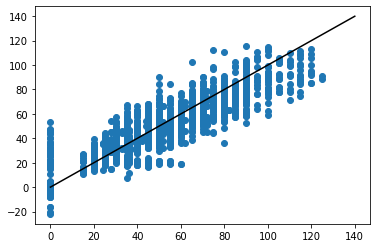

In [21]:
y_val_predict = reg.predict(X_val_scaled)
plt.scatter(y_val,y_val_predict)
plt.plot([0,140],[0,140],'-k')
plt.show()

In [22]:
score = reg.score(X_val_scaled,y_val)
print('linear regression score: {:.3f}'.format(score))

linear regression score: 0.760


### 6. Predicting the test dataset

In [25]:
#Change the name for the file (e.g. you last name, or a name for you algo)
name = 'lin_feature_processing'

y_test_predict = reg.predict(X_test_scaled)
np.save('test_predict.' + name + '.npy',y_test_predict)

#Send the file by email to julien.brajard@nersc.no